### Import packages

In [96]:
import argparse
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import re
import pathlib
from pathlib import Path
import numpy as np

### Import data

In [97]:
# Set the paths
base_path = "../../"
#base_path = pathlib.Path(__file__).parent.parent.parent
log_file_dir_path = pathlib.Path(base_path, "logs")
plot_dir_path = pathlib.Path(base_path, "analysis", "plots")
pypsa_earth_path = pathlib.Path(base_path, "workflow", "pypsa-earth")
network_path = pathlib.Path(pypsa_earth_path, "results", "US_2021", "networks", "elec_s_10_ec_lcopt_Co2L-24H.nc")
eia_generation_path = pathlib.Path(base_path, "analysis", "data", "generation_eia.csv")
generation_plot_path = pathlib.Path(plot_dir_path, "electricity_generation.png")
eia_capacity_path = pathlib.Path(base_path, "analysis", "data", "capacities_eia.xlsx")
installed_capacity_plot_path = pathlib.Path(plot_dir_path, "installed_capacity.png")

In [98]:
def extract_time_res(filename):
    filename = str(network_path.name)
    match = re.search(r'(\d+)H', filename)
    if match:
        return np.float64(match.group(1))
    else:
        return None

filepath = Path(network_path)
time_res = extract_time_res(filepath) # in hours

In [99]:
# Read reference data
df_eia_generation = pd.read_csv(eia_generation_path, index_col="Unnamed: 0")
df_eia_capacity = pd.read_excel(eia_capacity_path, skiprows=1, index_col="Energy Source")

In [100]:

# Parse argument
year_list = df_eia_generation["Period"].unique().tolist()
parser = argparse.ArgumentParser()
parser.add_argument("--year", help="Year to consider for the comparison", 
                    default=2020, type=int, choices=year_list)

# Modify sys.argv to work in Jupyter/IPython environments
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]  # Remove unwanted args

args = parser.parse_args()

# Ensure the logs directory exists
pathlib.Path(log_file_dir_path).mkdir(exist_ok=True)

# Ensure the plots directory exists
pathlib.Path(plot_dir_path).mkdir(exist_ok=True)

In [101]:
df_network = pypsa.Network(network_path)
df_eia_generation_year = df_eia_generation.loc[df_eia_generation["Period"] == args.year].squeeze()

s_max_pu = df_network.lines["s_max_pu"].unique()[0]

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' 

In [102]:
df_network.statistics().round(1)

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           1.0         2.504541e+09   
            Coal                              0.9         4.951451e+10   
            Combined-Cycle Gas                0.3         2.372181e+10   
            Csp                               NaN         0.000000e+00   
            Geothermal                        1.0         1.161880e+09   
            Nuclear                           1.0         4.602384e+10   
            Offshore Wind (AC)                NaN         0.000000e+00   
            Offshore Wind (DC)                NaN         0.000000e+00   
            Oil                               0.0         5.043723e+09   
            Onshore Wind                      0.3         2.351957e+10   
            Open-Cycle Gas                    0.0         1.816447e+10   
            Solar                             0.2         7.250205e+09   
Line        AC                                0.3         1.512571e+10   
Link        B2B                               0.9         0.000000e+00   
            Csp                               NaN         0.000000e+00   
            DC                                0.7         1.141777e+09   
            H2 electrolysis                   NaN         0.000000e+00   
            H2 fuel cell                      NaN         0.000000e+00   
            battery charger                   NaN         0.000000e+00   
            battery discharger                NaN         0.000000e+00   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              0.0         3.532078e+09   
            Reservoir & Dam                   0.4         0.000000e+00   
Store       Battery Storage                   NaN         0.000000e+00   
            Csp                               NaN         0.000000e+00   
            Hydrogen Storage                  NaN         0.000000e+00   

                                  Curtailment      Dispatch  \
            carrier                                           
Generator   Biomass                       0.0  5.955398e+07   
            Coal                          0.0  1.562430e+09   
            Combined-Cycle Gas            0.0  7.161029e+08   
            Csp                           0.0  0.000000e+00   
            Geothermal                    0.0  3.473515e+07   
            Nuclear                       0.0  8.710506e+08   
            Offshore Wind (AC)            0.0  0.000000e+00   
            Offshore Wind (DC)            0.0  0.000000e+00   
            Oil                           0.0  2.127225e+05   
            Onshore Wind                144.1  3.272330e+08   
            Open-Cycle Gas                0.0  1.885015e+07   
            Solar                        50.2  1.002768e+08   
Line        AC                            NaN  1.297568e+08   
Link        B2B                           NaN  3.190844e+07   
            Csp                           NaN  0.000000e+00   
            DC                            NaN -3.761252e+07   
            H2 electrolysis               NaN  0.000000e+00   
            H2 fuel cell                  NaN  0.000000e+00   
            battery charger               NaN  0.000000e+00   
            battery discharger            NaN  0.000000e+00   
Load        -                             NaN -3.988187e+09   
StorageUnit Pumped Hydro Storage          0.0  0.000000e+00   
            Reservoir & Dam               0.0  2.977415e+08   
Store       Battery Storage               NaN  0.000000e+00   
            Csp                           NaN  0.000000e+00   
            Hydrogen Storage              NaN  0.000000e+00   

                                  Installed Capacity  Market Value  \
            carrier                                                  
Generator   Biomass                           6798.4    

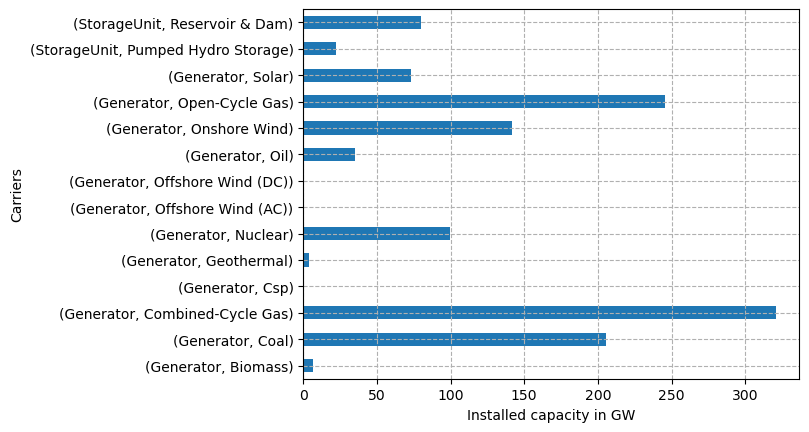

In [103]:
stats = df_network.statistics().round(1)["Installed Capacity"] / 1e3
installed_cap = stats.loc[["Generator","StorageUnit"]]
# installed_cap = installed_cap.drop(('Generator','load'))
installed_cap.plot(kind='barh')
plt.xlabel("Installed capacity in GW")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

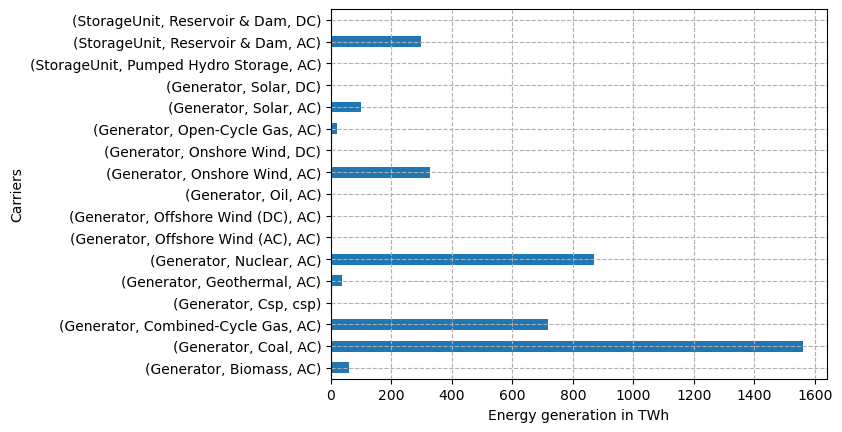

In [104]:
stats = df_network.statistics.energy_balance() / 1e6
energy_gen = stats.loc[["Generator","StorageUnit"]]
# energy_gen = energy_gen.drop(('Generator','load'))
energy_gen.plot(kind='barh')
plt.xlabel("Energy generation in TWh")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

In [105]:
df_network.generators = df_network.generators.assign(p = df_network.generators_t.p.sum() * time_res)
df_pypsa = df_network.generators.groupby("carrier").p.sum()
# df_pypsa.loc['coal'] += df_pypsa.loc['lignite']
df_pypsa.loc['wind'] = df_pypsa.loc[["offwind-ac","offwind-dc","onwind"]].sum()
df_pypsa = df_pypsa.drop(["offwind-ac","offwind-dc","onwind"])
df_pypsa /= 1e6
df_pypsa = df_pypsa.round(2)
df_pypsa.name = 'pypsa'

In [106]:
# Initial configurations
eia_name = "EIA"
pypsa_name = "PyPSA"

# Electricity generation comparison

## Installed capacity

In [107]:
# ---> Prepare the PyPSA results
df_pypsa_hydro_phs_capacity = df_network.storage_units.groupby("carrier").p_nom_opt.sum()
df_pypsa_capacity = pd.concat([df_network.generators.groupby("carrier").p_nom_opt.sum(), df_pypsa_hydro_phs_capacity])
df_pypsa_capacity.loc["wind"] = df_pypsa_capacity.loc[["offwind-ac", "offwind-dc", "onwind"]].sum()
df_pypsa_capacity = df_pypsa_capacity.drop(["offwind-ac", "offwind-dc", "onwind"])
df_pypsa_capacity /= 1000
df_pypsa_capacity = df_pypsa_capacity.round(2)
df_pypsa_capacity.name = pypsa_name

df_pypsa_capacity

carrier
CCGT          320.68
OCGT          245.55
biomass         6.80
coal          205.45
csp             0.00
geothermal      3.97
nuclear        99.44
oil            35.42
solar          73.11
PHS            21.99
hydro          79.83
wind          141.74
Name: PyPSA, dtype: float64

In [108]:
# ---> Prepare the EIA reference data
df_eia_capacity.index = df_eia_capacity.index.str.lower()
df_eia_capacity.loc["other biomass"] = df_eia_capacity.loc[["other biomass", "wood and wood-derived fuels"]].sum()
df_eia_capacity = df_eia_capacity.rename(index={"hydroelectric conventional": "hydro", "hydroelectric pumped storage": "PHS" , "solar photovoltaic": "solar", "natural gas": "CCGT", "petroleum": "oil", "other biomass": "biomass"})
df_eia_capacity = df_eia_capacity.drop(["estimated total solar", "solar thermal", "wood and wood-derived fuels", "other energy sources", "total", "small scale photovoltaic", "estimated total photovoltaic", "other gases",])
df_eia_capacity = df_eia_capacity.iloc[:-1]
df_eia_capacity.loc["solar", "Generator Nameplate Capacity"] = df_eia_capacity.loc["solar", "Net Summer Capacity"]
df_eia_capacity = df_eia_capacity["Generator Nameplate Capacity"]
df_eia_capacity.name = eia_name
df_eia_capacity /= 1000


In [109]:
# ---> Prepare comparison dataframe
df_compare_capacity = pd.concat([df_pypsa_capacity, df_eia_capacity], axis=1)

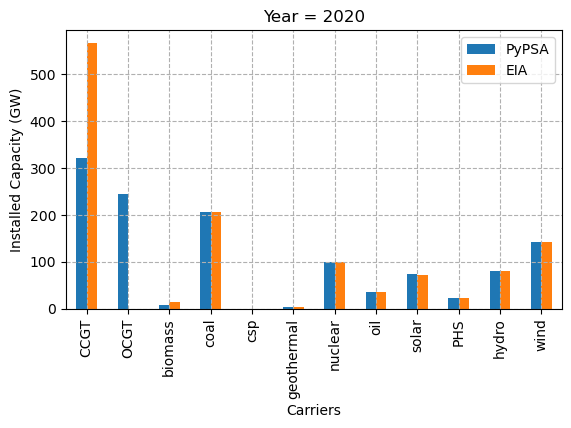

In [110]:
df_compare_capacity.plot(kind="bar")
plt.xlabel("Carriers")
plt.ylabel("Installed Capacity (GW)")
plt.title(f"Year = {args.year}")
plt.grid(linestyle="--")
plt.subplots_adjust(bottom=0.3)
plt.savefig(installed_capacity_plot_path, dpi=800)

In [111]:
df_compare_capacity.sum()

PyPSA      1233.98
EIA      1239.3987
dtype: object

## Total Electricity Demand in TWh

In [112]:
df_network.loads_t.p.sum().sum() * time_res / 1e6

3988.186546425629

## Total Electricity Generation in TWh

In [113]:
df_network.generators_t.p.sum().sum() * time_res / 1e6

3690.4450585800005

# Dispatch timeseries in GW

In [114]:
def plot_dispatch(n, time="2015-07"):

    # if not n.links.empty:
    #     links = (
    #         n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3) * -1
    #     )
    #     links = links[conv_carriers]
    #     p_by_carrier = links
    n.carriers.loc['load','color'] = 'black'
    carrier_order = ["nuclear","CCGT","OCGT","oil","coal","solar","onwind","offwind-ac","offwind-dc","geothermal","biomass"]
    gen_car = n.generators.query('carrier != "load"').carrier.unique()
    generators = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    p_by_carrier = generators[carrier_order]

    if not n.storage_units.empty:
        sto = (
            n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        )
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
#             color=charge.columns.map(n.carriers.color)
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k",linewidth=0.1)

    plt.legend(loc=(1.05, 0),fontsize=8)
    handles = ax.legend_.legendHandles
    labels = [elt.get_text() for elt in ax.legend_.texts]
    ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1.1))
    ax.set_ylabel("GW")
    ax.set_ylim(-5, 1000)
#     plt.subplots_adjust(right=0.8)
    ax.grid(linestyle="--")
    plt.savefig("../plots/dispatch_timeseries_24H.png",dpi=800)

In [115]:
df_network.generators.query('carrier != "load"').carrier.unique()

array(['CCGT', 'OCGT', 'biomass', 'coal', 'csp', 'nuclear', 'offwind-ac',
       'offwind-dc', 'oil', 'onwind', 'solar', 'geothermal'], dtype=object)

/tmp/ipykernel_13874/1408331278.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  generators = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
/tmp/ipykernel_13874/1408331278.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)


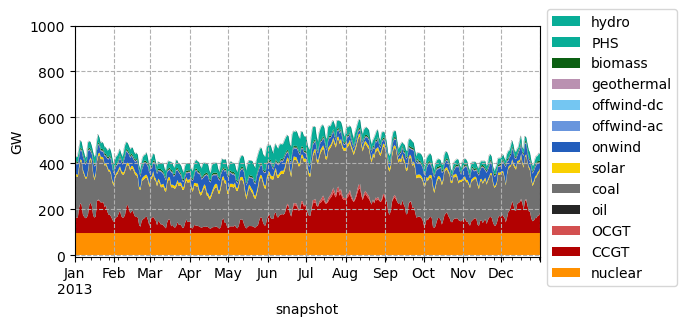

In [116]:
plot_dispatch(df_network,"2013")

In [117]:
from pypsa.plot import add_legend_patches, add_legend_circles, add_legend_lines
import cartopy.crs as ccrs
from cartopy.feature import LAND, BORDERS
import random

def plot_map(n,plot_type,key):
    carriers = n.carriers.index.tolist()[:-2]
    buses = n.buses.query('carrier == "AC" and index != "US0 7"')
    bus_index = buses.index.tolist()
    fig = plt.figure(figsize=(15,12))
    # fig = plt.figure()
    ax = plt.axes(projection=ccrs.EqualEarth())
    n.lines.loc[n.lines.bus0 == 'US0 19','s_nom'] = 0
    gen_season = []

    # n.shapes.boundary.iloc[0:1].plot(ax=ax)

    if plot_type =="capacity":
        cap = n.generators.query("carrier != 'load' and bus in @bus_index").groupby(["bus", "carrier"]).p_nom.sum()
        cap = (cap[cap.index.get_level_values('bus') != 'US0 19'])
        # sto = n.storage_units.groupby(["bus","carrier"]).p_nom.sum()
        # capacities = pd.concat([cap,sto]).reset_index().groupby(["bus","carrier"]).p_nom.sum()
        n.plot(
            ax = ax,
            bus_sizes =  cap / 2e4,
            line_widths = n.lines.s_nom / 1e4,
            line_colors = 'rosybrown',
            margin = 0.25,
            bus_alpha = 0.7,
            # bus_text = n.buses.index.tolist()
            color_geomap = True,
            link_alpha = 0

        )
        
    if plot_type in ["capacity","generation","loads"]:
        values, sizes, labels = [],[],[]
        title = ""
        if plot_type == "capacity":
            values = n.generators.query("carrier != 'load' and bus in @bus_index").groupby("bus").p_nom.sum()
            sizes = np.sort(round(values/1e3).unique()*1e3/2e4)
            labels = np.sort(round(values/1e3).unique())
            title = "Capacity (GW)"

        if plot_type == "capacity":
            x_val = 1.25
        else:
            x_val = 1.35
    if plot_type == "capacity" or plot_type == "generation":
        
        add_legend_patches(
            ax, colors=n.carriers.color.tolist()[:-2], labels=carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1), title="Carriers")
        )
        
    # for bus in buses.itertuples():
    #     ax.text(bus.x, bus.y-3, bus.Index, color='black', size=8, ha='center', va='center', transform=ccrs.PlateCarree())

    ax.add_feature(LAND)
    ax.coastlines()
    # ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    ax.add_feature(BORDERS, alpha=1, edgecolor='black')

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


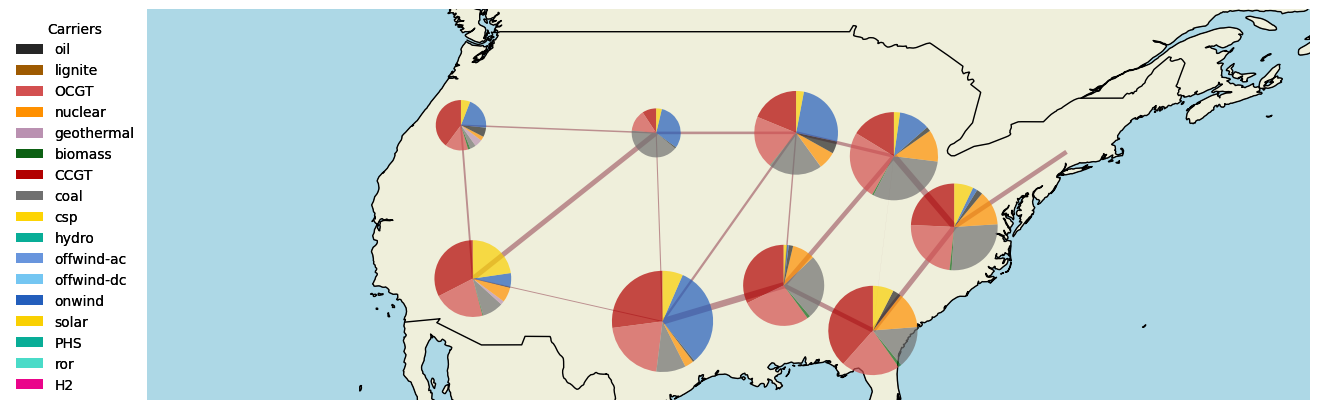

In [118]:
plot_map(df_network,"capacity","")

# Demand timeseries in GW

<AxesSubplot:xlabel='snapshot'>

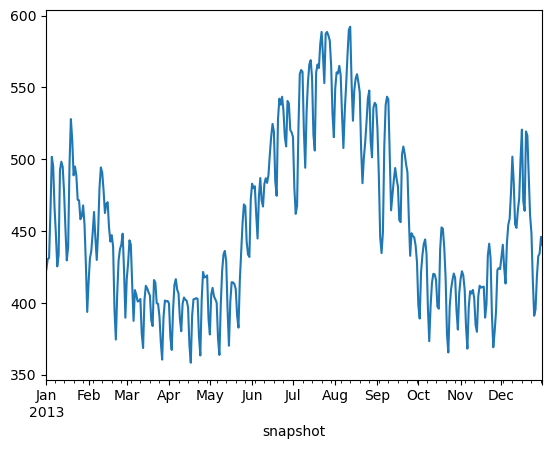

In [128]:
(df_network.loads_t.p_set.sum(axis=1) / 1e3).plot()

# Generation timeseries in GW

<AxesSubplot:xlabel='snapshot'>

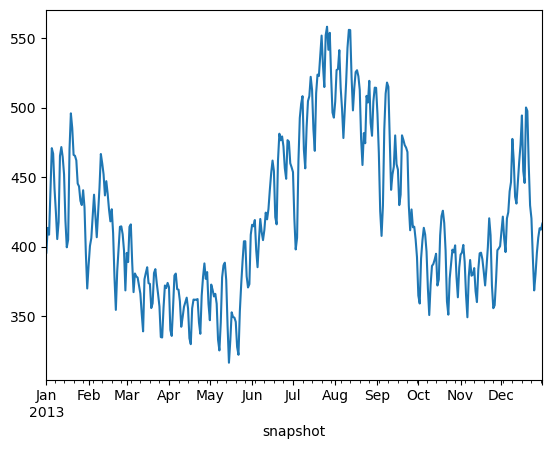

In [129]:
(df_network.generators_t.p.sum(axis=1) / 1e3).plot()

In [130]:
df_eia_monthly = pd.read_csv("../data/monthly_generation_US.csv",skiprows=4)
df_eia_monthly = df_eia_monthly.dropna(axis=0)
# df_eia_monthly = df_eia
df_eia_monthly.sort_index(ascending=False)[1:-1].reset_index()

,index,Month,all fuels (utility-scale) thousand megawatthours,coal thousand megawatthours,natural gas thousand megawatthours,nuclear thousand megawatthours,conventional hydroelectric thousand megawatthours,other renewables thousand megawatthours,hydro-electric pumped storage thousand megawatthours,other gases thousand megawatthours,petroleum liquids thousand megawatthours
0,22,Jan 2021,180728.45032,66231.49971,53913.46978,34339.450,18611.53183,6207.66901,-339.236,5.19332,1188.16274
1,21,Feb 2021,163642.61950,46241.08298,53745.50684,35324.705,18970.96776,8346.53567,-141.503,8.61941,599.04253
2,18,Mar 2021,151505.03330,40783.61682,54242.56159,30125.961,17255.70913,8281.45845,-101.948,-0.38473,611.02053
3,17,Apr 2021,170418.81556,49416.68259,57584.38116,33490.728,21177.86466,8037.76082,-322.855,-0.28468,635.12736
4,14,May 2021,207175.70902,66423.90191,74851.67559,36854.337,21826.51122,6434.49710,-269.964,-0.27507,671.97540
5,13,Jun 2021,226361.26789,76451.54978,84946.61256,38370.528,20109.28476,5808.25001,-550.845,-0.26008,652.04572
6,10,Jul 2021,227826.91444,77465.31171,85233.24209,38751.840,18598.49465,6727.14729,-531.015,-0.27507,935.49064
7,9,Aug 2021,185991.21152,60310.64295,66831.68497,35305.664,15288.52205,7301.00061,-313.409,0.00000,740.36142
8,8,Sep 2021,166407.27799,45722.47543,62206.18236,34522.285,15382.67232,7659.95553,-333.460,0.00000,690.40235
9,5,Oct 2021,162701.85066,41645.58231,58942.31276,34882.319,17372.67955,8852.16839,-301.523,0.00000,647.13462


In [131]:
df_pypsa_grouped = df_network.generators_t.p.groupby(df_network.generators.carrier,axis=1).sum() * 24
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.sum(axis=1).div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

/tmp/ipykernel_13874/150945805.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_pypsa_grouped = df_network.generators_t.p.groupby(df_network.generators.carrier,axis=1).sum() * 24


0     326.174424
1     279.492098
2     276.986738
3     258.815759
4     268.802913
5     315.561991
6     371.260697
7     379.552842
8     326.601423
9     288.115933
10    276.533160
11    322.547081
Name: PyPSA, dtype: float64

In [132]:
df_eia = pd.read_excel("../data/Table_7.2a_Electricity_Net_Generation__Total_(All_Sectors).xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Net Generation Total (including from sources not shown), All Sectors"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0     349.209709
1     323.899529
2     311.397276
3     293.307944
4     320.180962
5     373.856478
6     405.624091
7     412.864768
8     347.743775
9     320.201778
10    314.309521
11    337.103561
Name: EIA, dtype: object

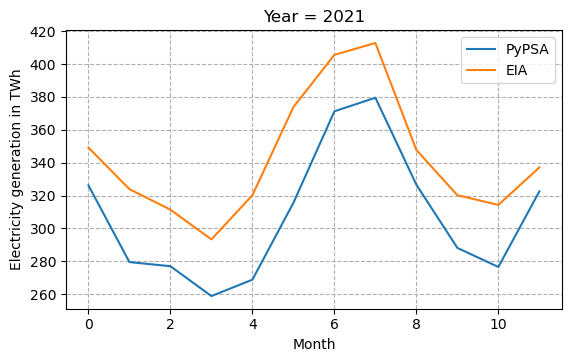

In [133]:
df_compare_gen_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021],axis=1)
df_compare_gen_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity generation in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_gen_ts.png",dpi=800)

In [134]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity End Use, Total"]
# df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Sales to Ultimate Customers, Total"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0      333.97653
1     309.816283
2     306.272657
3      283.32879
4     301.122292
5     350.199269
6     386.625923
7     393.627941
8     347.832293
9     313.613342
10    298.838866
11    319.535135
Name: EIA, dtype: object

In [135]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2020 = df_eia.loc[df_eia.Month.dt.year == 2020].reset_index()
df_eia_monthly_2020 = df_eia_monthly_2020["Electricity End Use, Total"]
df_eia_monthly_2020 = df_eia_monthly_2020 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2020.name = 'EIA 2020'
df_eia_monthly_2020

0     328.246135
1     306.425243
2       301.7527
3     273.132424
4     285.627076
5     331.355301
6     391.577954
7     380.979969
8     333.682753
9     307.869372
10    288.228154
11    327.499941
Name: EIA 2020, dtype: object

In [137]:
df_pypsa_grouped = df_network.loads_t.p.sum(axis=1) * time_res
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

0     346.021667
1     297.342062
2     298.848573
3     285.545290
4     309.043998
5     361.021042
6     405.248279
7     402.285108
8     345.081304
9     306.702148
10    291.793785
11    339.253291
Name: PyPSA, dtype: float64

In [138]:
# df_bev = pd.read_csv("../data/demand_BEV.csv")
df_bev = pd.read_csv("../data/demand_basegrid.csv")
df_bev = df_bev.set_index("UTC Time")
df_bev_monthly = df_bev.groupby(pd.to_datetime(df_bev.index).month).sum()
# df_bev_monthly = df_bev_monthly.sum() 
df_bev_monthly = df_bev_monthly.sum(axis=1)
df_bev_monthly = df_bev_monthly / 1e6
df_bev_monthly.name = 'BEV'
df_bev_monthly.index = np.arange(0,12)
df_bev_monthly


0     346.611661
1     307.499217
2     299.358134
3     286.032168
4     309.570943
5     361.636612
6     405.939259
7     402.971036
8     345.669695
9     307.225100
10    292.291317
11    339.831745
Name: BEV, dtype: float64

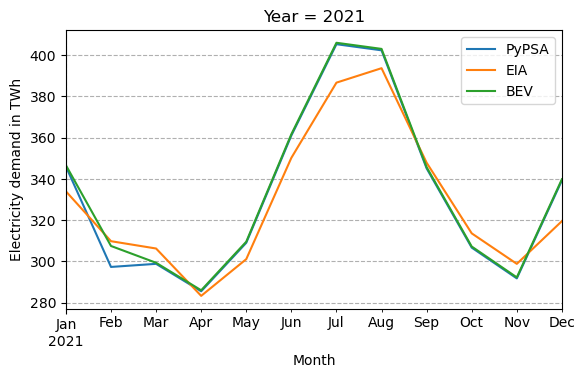

In [139]:
df_compare_dem_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021,df_bev_monthly],axis=1)
df_compare_dem_ts.index = df_eia.loc[df_eia.Month.dt.year == 2021].Month.tolist()
df_compare_dem_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity demand in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_demand_ts.png",dpi=800)

# CO2 emissions in Mtonnes

In [140]:
e = (
    df_network.generators_t.p
    / df_network.generators.efficiency
    * df_network.generators.carrier.map(df_network.carriers.co2_emissions)
)
emissions = df_network.snapshot_weightings.generators @ e.sum(axis=1).div(1e6)

In [141]:
emissions

1472.7999777066327